# Part 2: Rediscover the Higgs boson

In [1]:
import uproot
import uproot_methods.classes.TLorentzVector as LVepm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

# Step 1: Access a the data file and convert into a 'pandas dataframe'.


In [2]:
eventsData = uproot.open("data_Skim_GamGam.root")["mini"]
df = eventsData.pandas.df(["photon_pt", "photon_eta", "photon_phi", "photon_E",  "diphoton_mass"])

# Step 2. Apply a series of event selections
    - only select events containing two photons with specific pt and \eta

In [3]:
cuts0 = df[(df["photon_pt[0]"] > 35000)  & (df["photon_pt[1]"] > 25000 )]

cuts1 = cuts0[( np.abs(cuts0["photon_eta[0]"]) < 2.37)  & ( np.abs(cuts0["photon_eta[1]"]) < 2.37 )]

#alternative eta cut, selects central photons only
#cuts1 = cuts0[( np.abs(cuts0["photon_eta[0]"]) < 0.75)  & ( np.abs(cuts0["photon_eta[1]"]) < 0.75 )]

#these cuts exclude a small region of the ATLAS detector known to have poor efficiency and resolution.
cuts1a = cuts1[ (np.abs(cuts1["photon_eta[0]"]) < 1.37) | (np.abs(cuts1["photon_eta[0]"]) > 1.52) ]
cuts1b = cuts1a[ (np.abs(cuts1a["photon_eta[1]"]) < 1.37) | (np.abs(cuts1a["photon_eta[1]"]) > 1.52) ]


cuts2a = cuts1b[(cuts1b["photon_pt[0]"] / cuts1b["diphoton_mass"])  > 0.35]
cuts2b = cuts2a[(cuts2a["photon_pt[1]"] / cuts2a["diphoton_mass"])  > 0.25]

cuts3 = cuts2b[(cuts2b["diphoton_mass"]  > 105000) & (cuts2b["diphoton_mass"]  < 160000) ]

finalData =  cuts3

print("Number of selected events = " + str(len(finalData.index)))

finalData

Number of selected events = 76382


,photon_pt[0],photon_pt[1],photon_eta[0],photon_eta[1],photon_phi[0],photon_phi[1],photon_E[0],photon_E[1],diphoton_mass
entry,,,,,,,,,
1,176121.156250,39629.144531,-0.833492,0.094703,-0.294239,0.567294,240922.312500,39806.988281,106420.710938
5,59702.843750,36279.230469,-0.496725,0.944734,-1.249765,1.442561,67220.937500,53709.812500,116489.304688
9,59590.574219,48349.218750,0.677454,1.657661,1.073675,-1.483528,73796.007812,131452.093750,116470.882812
12,73188.804688,62626.109375,-0.012039,-0.931096,0.486101,-2.276066,73194.109375,91791.382812,147763.281250
13,60071.027344,40881.761719,-2.054557,-0.305891,3.055348,1.028946,238227.640625,42809.355469,129235.617188
...,...,...,...,...,...,...,...,...,...
362845,56698.496094,54673.269531,0.968195,-0.731186,-0.846178,2.167801,85415.046875,69951.195312,153864.140625
362847,59611.757812,27660.048828,0.042606,1.664608,-0.876788,2.817131,59665.871094,75689.875000,107152.179688
362856,57474.222656,55986.339844,0.208165,0.189044,0.076922,-3.027287,58723.980469,56989.730469,113436.171875


# Step 3. Combine the four vectors of the photons

In [4]:
flatData0 = LVepm.TLorentzVectorArray.from_ptetaphi(finalData["photon_pt[0]"], finalData["photon_eta[0]"], finalData["photon_phi[0]"],finalData["photon_E[0]"])
flatData1 = LVepm.TLorentzVectorArray.from_ptetaphi(finalData["photon_pt[1]"], finalData["photon_eta[1]"], finalData["photon_phi[1]"],finalData["photon_E[1]"])

flatData = flatData0 + flatData1

# Step 4. Create a histogram of the masses of the diphoton system.

In [5]:
mH = 124894.0
sigmaH = 210.0

#example binning
nBins = 30
minMass = 105000
maxMass = 160000

countsData, edges = np.histogram(flatData.mass, bins=nBins, range=(minMass,maxMass))

#create an array of the centre of each bin, useful for plotting the pdf later
centres = (edges[1:] + edges[:-1]) / 2

# Step 5. Fit a background model to data and make a comparison plot.

- create a statistical model for the diphoton mass distribution composed of of a gaussian ('norm') pdf for the $H\rightarrow \gamma \gamma$ process and a third-order polynomial fuction for the background diphoton processes. The mean of the signal gauusian distribution is chosen as the measured $m_{H}$ value.

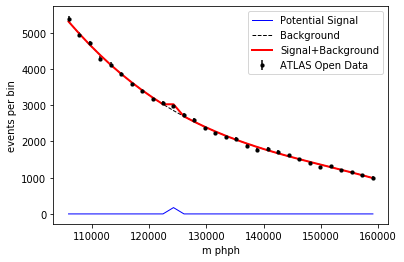

In [6]:
b = np.poly1d(np.polyfit(centres, countsData, 3))

#guess a signal integral for illustration purposes
integral = 10113802.23

s = ( scipy.stats.norm.pdf(centres, mH, sigmaH) * integral)
sb = s+b(centres)

plt.figure()
plt.xlabel("m phph")
plt.ylabel("events per bin")
plt.plot(centres, s, 'b', linewidth=1, label="Potential Signal")
plt.plot(centres, b(centres), 'k', linewidth=1, linestyle="--", label="Background")
plt.plot(centres, sb, 'r', linewidth=2, label="Signal+Background")

plt.errorbar(centres, countsData, yerr=np.sqrt(countsData), fmt='o', mfc='k', mec='k',ms=4, mew=0.2, ecolor='k',label="ATLAS Open Data",)
plt.legend()

# Step 6. Create a plot of the binned "residuals" vs $m_{H}$

- Subtract the polynomial background prediction from the data to calculate the \emph{residuals}. 
- The residual in each bin is our estimate of the signal in that bin.

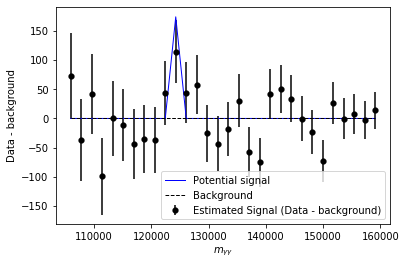

CPU times: user 354 ms, sys: 26.6 ms, total: 380 ms
Wall time: 387 ms


In [7]:
%%time
#ratio plot 
residuals = countsData - b(centres) 
plt.figure()
plt.xlabel("$ m_{\gamma\gamma}$")
plt.ylabel("Data - background")
plt.errorbar(centres, residuals, yerr=np.sqrt(countsData), label="Estimated Signal (Data - background)", fmt='o', mfc='k', mec='k', mew=0.2, ecolor='k')

nSteps = 100

plt.plot(centres, s, 'b', linewidth=1, label="Potential signal")
plt.plot(centres, np.zeros(len(centres)), 'k', linewidth=1, linestyle="--", label="Background")
plt.legend()
plt.show()

# Step 7.  Simultaneously fit  $m_{H}$, $\Gamma_{H}$ and $N_{H\rightarrow\gamma\gamma}$ from the residuals
- If we assume the signal will have a gaussian shape with $\mu \approx m_{H} \approx$ 125000 MeV, we can use python libraries to fit a gaussian distrubution to the residual graph and estimate the number of signal events $N_{H\rightarrow\gamma\gamma}$ in the data as well as $m_{H}$ and $\Gamma_{H}$.

best fitting parameters:
MH = 124437.52136005287
sigmaH = 110.93544019327686
NH = 728.2075326692104


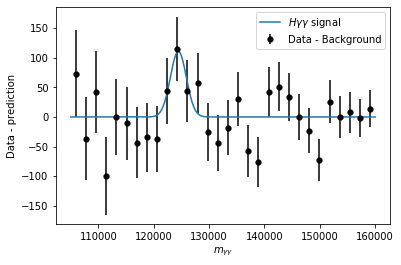

In [8]:
#assume mass, sigma
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

bestFitParams, covarianceMatrix = curve_fit(gaussian, centres, residuals, p0=[125000., 200., 1000.])

#the p0 values are that the 'starting points' for 𝑚𝐻, Γ𝐻 and 𝑁𝐻→𝛾𝛾 in the fit.

x_interval_for_fit = np.linspace(edges[0], edges[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *bestFitParams), label='$ H \gamma \gamma$ signal')
plt.errorbar(centres, residuals, yerr=np.sqrt(countsData), label="Data - Background", fmt='o', mfc='k', mec='k', mew=0.2, ecolor='k')
plt.legend()
plt.xlabel("$ m_{\gamma\gamma}$")
plt.ylabel("Data - prediction")

# add the values of thr fitted signal shape at a series of points to estimate the total 
# number of signal events
limA = 11500
limA = 13500
sigIntegral = 0.0
stepSize = (maxMass - minMass)/(nSteps)

xStep = minMass

for p in range(0, nSteps):
        xStep = xStep + stepSize
        sigHeight = gaussian(xStep, *bestFitParams)
        #print(sigHeight)
        sigIntegral = (sigIntegral + (sigHeight) )

print("best fitting parameters:")
print("MH = " + str(float(bestFitParams[0])))
print("sigmaH = " + str(float(bestFitParams[1]) ))
print("NH = " + str(float(sigIntegral) ))

# Step 8  Estimate the statistical significance of the $H\rightarrow \gamma \gamma$ signal.




In [9]:
#Your code goes here!

# Step 9 - Your turn!

It's time for you to try improvements to the analysis especially if they can improve the significance of the signal.
Refer to the lab manual for suggested modifications.

